In [1]:
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
# https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

In [2]:
# Lấy thông tin các GPU có sẵn
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Cho phép bộ nhớ GPU phát triển (tăng trưởng theo nhu cầu)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except RuntimeError as e:
        print(e)


Memory growth enabled for GPU.


In [3]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [4]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename=filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav 

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

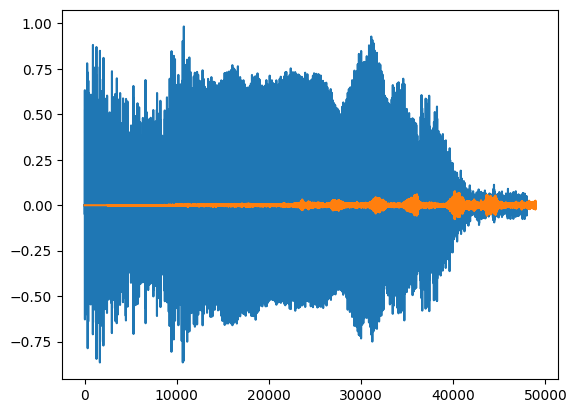

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()


In [7]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [8]:
pos = tf.data.Dataset.list_files(POS + '\*.wav')
neg = tf.data.Dataset.list_files(NEG + '\*.wav')

In [9]:
pos.as_numpy_iterator().next(), neg.as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC387509-4.wav',
 b'data\\Parsed_Not_Capuchinbird_Clips\\night-insect-sounds-13.wav')

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [11]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_Clips\\afternoon-birds-song-in-forest-21.wav',
 0.0)

In [12]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [13]:
print('This is reduce max -->', tf.math.reduce_max(lengths).numpy())
print('This is reduce min -->', tf.math.reduce_min(lengths).numpy())
print('This is reduce mean -->', tf.math.reduce_mean(lengths).numpy())

This is reduce max --> 80000
This is reduce min --> 32000
This is reduce mean --> 54156


In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

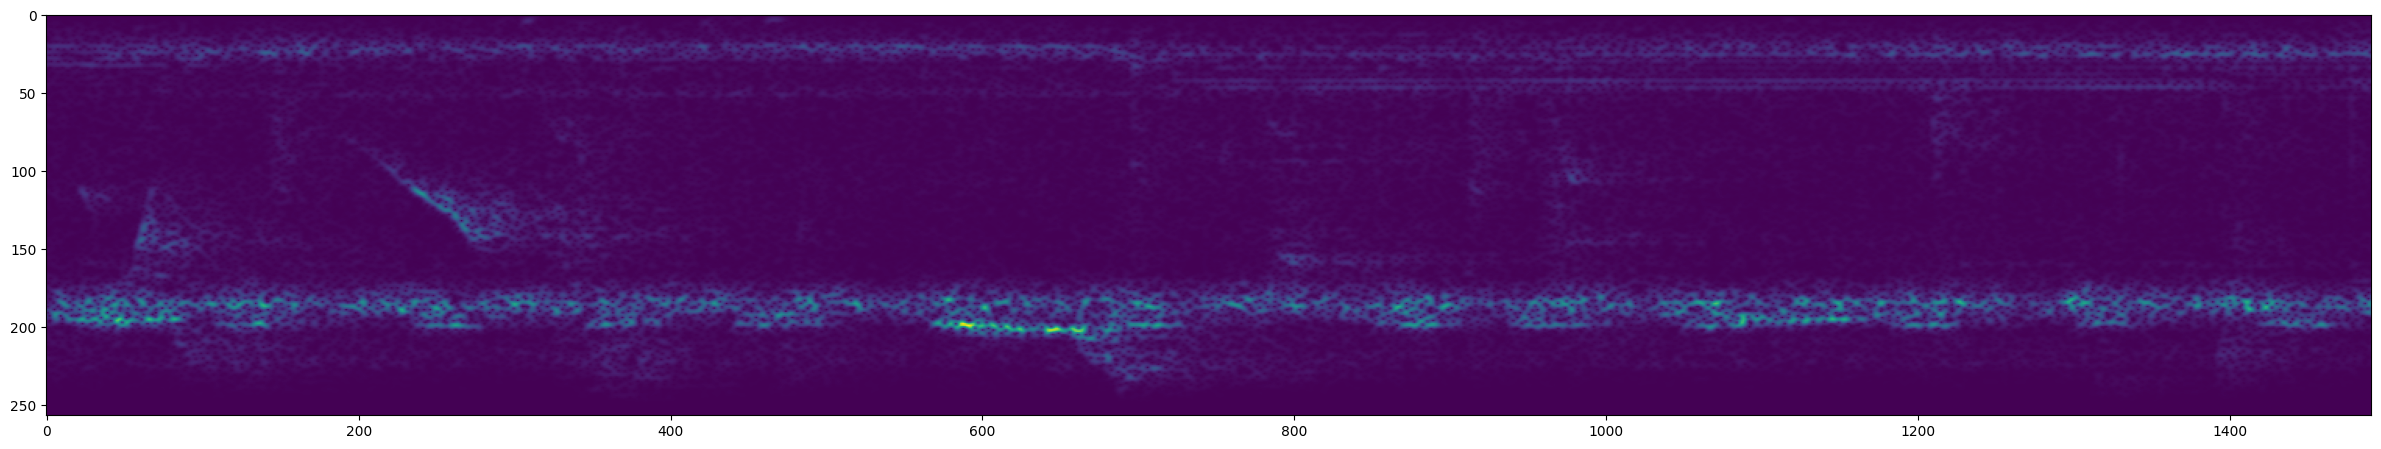

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [16]:
# spectrogram

In [17]:
dataset = data.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [18]:
train = dataset.take(36)
test = dataset.skip(36).take(15)

In [19]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [21]:
with tf.device('/device:cpu:0'):
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [23]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 95s 2s/step - loss: 13.1505 - recall: 0.8408 - precision: 0.8250 - val_loss: 0.2603 - val_recall: 0.8939 - val_precision: 0.9516
Epoch 2/4
36/36 [==============================] - 87s 2s/step - loss: 0.1671 - recall: 0.9281 - precision: 0.9726 - val_loss: 0.1608 - val_recall: 0.9851 - val_precision: 0.7586
Epoch 3/4
36/36 [==============================] - 86s 2s/step - loss: 0.0875 - recall: 0.9879 - precision: 0.9760 - val_loss: 0.0417 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 88s 2s/step - loss: 0.0420 - recall: 0.9878 - precision: 1.0000 - val_loss: 0.0285 - val_recall: 1.0000 - val_precision: 1.0000


In [24]:
!nvidia-smi

Fri Dec 20 10:17:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 59%   52C    P2             72W /  270W |    7622MiB /   8192MiB |     77%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

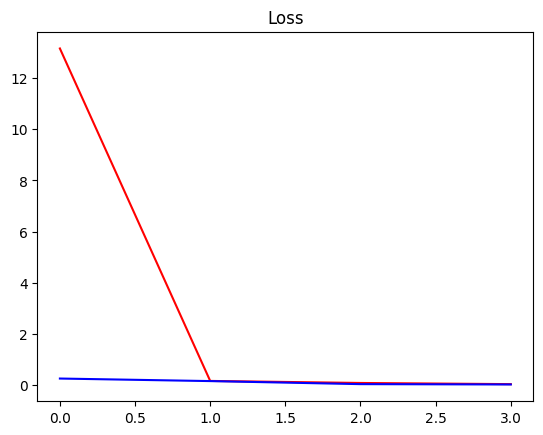

In [25]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

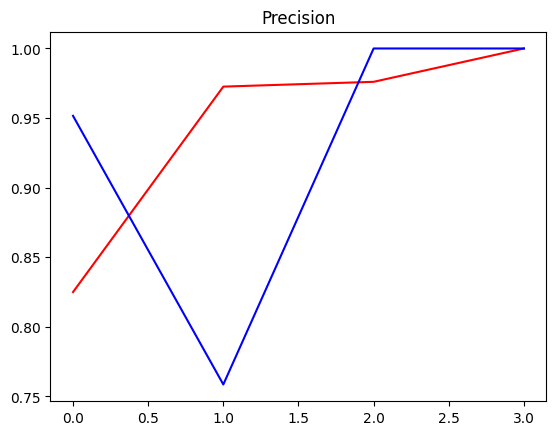

In [26]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

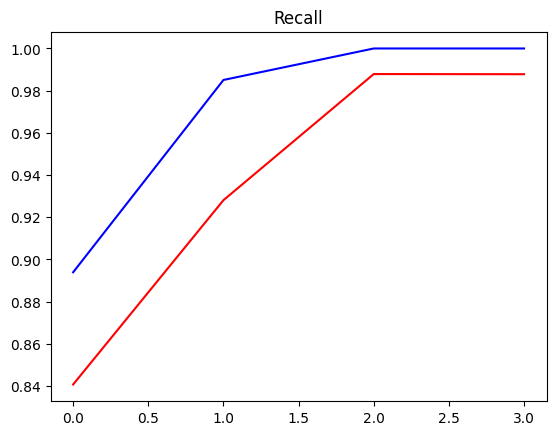

In [27]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [28]:
X_test, y_test = test.as_numpy_iterator().next()

In [29]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 786ms/step


In [30]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [31]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [32]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [33]:
wav = load_mp3_16k_mono(mp3)

In [34]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [35]:
samples, index = audio_slices.as_numpy_iterator().next()

In [36]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [37]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [47]:
with tf.device('/CPU:0'):
    yhat = model.predict(audio_slices)
    yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 [==============================] - 2s 2s/step


In [48]:
from itertools import groupby

In [49]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [50]:
calls

13

In [52]:
with tf.device('/CPU:0'):
    results = {}
    for file in os.listdir(os.path.join('data', 'Forest Recordings')):
        FILEPATH = os.path.join('data','Forest Recordings', file)
        
        wav = load_mp3_16k_mono(FILEPATH)
        audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
        audio_slices = audio_slices.map(preprocess_mp3)
        audio_slices = audio_slices.batch(64)
        
        yhat = model.predict(audio_slices)
        
        results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [53]:
results

{'recording_00.mp3': array([[3.1517938e-01],
        [1.7277776e-01],
        [6.1923558e-01],
        [2.8416976e-02],
        [1.0000000e+00],
        [9.9784039e-02],
        [3.1752712e-01],
        [3.7297371e-01],
        [6.4932488e-02],
        [5.5117619e-01],
        [4.2591861e-01],
        [3.3180594e-01],
        [3.3356440e-01],
        [6.9492096e-03],
        [1.0000000e+00],
        [3.9311087e-01],
        [2.2658383e-04],
        [3.0411279e-01],
        [4.9348223e-01],
        [6.3302183e-01],
        [4.7508141e-01],
        [4.2910787e-01],
        [6.5860766e-01],
        [7.6522774e-01],
        [1.0000000e+00],
        [5.6211078e-01],
        [1.1649971e-01],
        [4.0386215e-01],
        [7.9621387e-01],
        [3.7717953e-01],
        [3.6996812e-01],
        [4.1803268e-01],
        [1.9169079e-02],
        [2.1760628e-02],
        [4.7797370e-01],
        [1.9146802e-01],
        [1.0000000e+00],
        [5.9487754e-01],
        [3.7304971e-01],
     

In [54]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [55]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 3,
 'recording_17.mp3': 16,
 'recording_18.mp3': 10,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 3,
 'recording_29.mp3': 4,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 16,
 'recording_39.mp3': 2,
 'recording_40.mp3': 1,
 'recording_

In [56]:

import csv

In [57]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])